In [10]:

import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import pandas as pd
from torch.utils.data import TensorDataset,DataLoader
import joblib
import requests
from tqdm import tqdm_notebook as tqdm
from pytorch_lightning import seed_everything
import random
import warnings 
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)

def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# config

In [11]:
# Load data
data = joblib.load('..\data\dataset.pkl')

data['value'] = data['value'][:,[0]]
data['value_col'] = data['value_col'][:1]

batch_size = 32
hidden_size = 128
state_size = data['state'].shape[-1]
request_size = data['value'].shape[-1]
value_size = data['value'].shape[-1]
action_size = data['action'].shape[-1]
time_step = 144


,H-110 裂解度
count,1064.000000
mean,0.000183
std,0.000031
min,0.000000
25%,0.000180
50%,0.000188
75%,0.000195
max,0.000246


,0
count,1064.000000
mean,0.000217
std,0.000017
min,0.000189
25%,0.000202
50%,0.000217
75%,0.000231
max,0.000246


,H-110 裂解度
count,1064.000000
mean,0.000183
std,0.000031
min,0.000000
25%,0.000180
50%,0.000188
75%,0.000195
max,0.000246


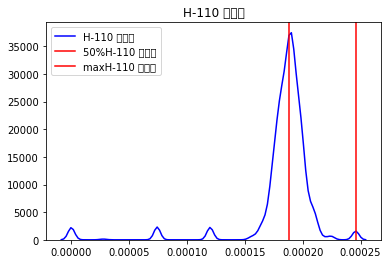

(1064, 144, 8)
(1064, 144, 9)
(1064, 1)
(1064, 1)


In [12]:
a = pd.DataFrame(data['value'],columns=data['value_col']).describe()
display(a)

data['request'] = None
for i in data['value_col']:
    if data['request'] is None:
        data['request'] = np.random.uniform(low=a.loc['50%',i],high=a.loc['max',i],size=(data['value'].shape[0],1))
    else:
        var = np.random.uniform(low=a.loc['50%',i],high=a.loc['max',i],size=(data['value'].shape[0],1))
        data['request'] = np.hstack([data['request'],var])
b = pd.DataFrame(data['request']).describe()
display(b)

a = pd.DataFrame(data['value'],columns=data['value_col'])
display(a.describe())
for i in data['value_col']:
    sns.kdeplot(a[i],color='b')
    plt.axvline(x=a.describe().loc['50%',i], label= "50%"+i, c='r')
    plt.axvline(x=a.describe().loc['max',i], label= "max"+i, c='r')
    plt.legend()
    plt.title(i)
    plt.show()
describe = a.describe()



# shape
print(data['state'].shape)
print(data['action'].shape)
print(data['value'].shape)
print(data['request'].shape)

# tensor
data['state'] = torch.FloatTensor(data['state'])
data['request'] = torch.FloatTensor(data['request'])
data['action'] = torch.FloatTensor(data['action'])
data['value'] = torch.FloatTensor(data['value'])



# data_iter
data = TensorDataset(data['state'],data['request'],data['action'],data['value'])
train_iter = DataLoader(data,batch_size=batch_size,shuffle=True)

# R2D2 MODEL

In [13]:

class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
  
  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = torch.tanh(hx)
    x = torch.sigmoid(self.l3(x)) # to range[0,1]
    return x,hx,cx


# ActorCritic Model

In [14]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step
    
    self.actor = actor
    self.actor_optimizer = MADGRAD(actor.parameters() ,lr = 1e-3)
    
    self.critic = critic
    self.critic_optimizer = MADGRAD(critic.parameters() ,lr = 1e-3)
  
  def forward(self,state,request):
    actions = self.actor_forward(state,request)
    values = self.critic_forward(state,actions)
    return values

  def actor_forward(self,state,request,eval=False):
    '''
    # 給定狀態(不可控)和需求 輸出一系列動作
    '''
    # train or eval model
    if eval == True:
      self.actor.eval()
    else:
      self.actor.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))
    
    # get actions shape(batch_size,time_step,action_size)
    actions = torch.FloatTensor()
    
    # 對一定時間長度進行遍歷
    for t in range(self.time_step):
      # 在t時刻 根據t時刻的狀態,需求以及短期記憶hx,長期記憶cx當作輸入,得到輸出a(動作),更新後的短期記憶hx,更新後的長期記憶cx
      a,hx,cx = self.actor(torch.cat((state[:,t,:],request),dim=1),hx,cx)
      actions = torch.cat((actions,a),dim=1)
    # 一系列動作 (Batch,Time,Features)
    actions = actions.reshape(state.size()[0],self.time_step,-1)
    
    return actions
  
  def critic_forward(self,state,action,eval=False):
    '''
    # 輸入狀態(不可控)和一系列動作(可控),預測產出
    '''

    # train or eval model
    if eval == True:
      self.critic.eval()
    else:
      self.critic.train()
    
    # initialize hx,cx
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))

    # get values shape(batch_size,time_step,value_size)
    values = torch.FloatTensor()
    
    # 對時間點遍歷
    for t in range(self.time_step):
      # 根據當前t時刻狀態,動作,hx,cx當輸入得到,v(產出),更新hx,cx
      v,hx,cx = self.critic(torch.cat((state[:,t,:],action[:,t,:]),dim=1),hx,cx)
      values = torch.cat((values,v),dim=1)
    
    # 一系列產出(Batch,Time,Features)
    values = values.reshape(state.size()[0],self.time_step,-1)
    
    # 只取最後一個時間點
    return values[:,-1,:] # return last time_step

  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''
    self.critic.train()
    self.actor.eval()
    value_hat = self.critic_forward(state,action)
    
    # 預測值跟label的平方差愈小愈好
    loss = ((value_hat-value)**2).mean()
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()
    return loss.item()
  
  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最小化產出跟request的差異'
    '''
    self.actor.train()
    self.critic.eval()
    actions = self.actor_forward(state,request)
    value_hat = self.critic_forward(state,actions)

    # 首先預測值跟需求的平方差愈小愈好
    loss1 = ((request-value_hat)**2).mean()

    # 再來避免"變異數太大(時間維度上)" 因為盤控人員不可能突然調太多
    loss2 = actions.reshape(-1,time_step,action_size).std(axis=1)
    loss2 = loss2.sum(axis=-1).mean(axis=0)

    loss = loss1 + loss2
    loss.backward()
    
    self.actor_optimizer.step()
    self.actor.zero_grad()

    return loss.item()

In [15]:
actor = R2D2(state_size+request_size,action_size,hidden_size)
critic = R2D2(state_size+action_size,value_size,hidden_size)
model = ActorCritic(actor,critic,time_step)

# train loop

In [16]:
def train_critic():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_critic(bs,ba,bv)
  return loss

def train_actor():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_actor(bs,br)
  return loss

def train(model,train_iter,epochs=100):
  train_history = {}
  train_history['actor'] = []
  train_history['critic'] = []
  
  for epoch in tqdm(range(epochs)):
    loss = train_critic()
    train_history['critic'].append(loss)
    if epoch % 10 == 0:
      print('epoch:{} critic_loss:{}'.format(epoch,loss))
    
  for epoch in tqdm(range(epochs)):
    loss = train_actor()
    train_history['actor'].append(loss)
    if epoch % 10 == 0:
      print('epoch:{} actor_loss:{}'.format(epoch,loss))
    
  return model,train_history

In [17]:
s,r,a,v = next(iter(train_iter))
print(s.shape,r.shape,a.shape,v.shape)
actions = model.actor_forward(s,r,eval=True)
print(actions.shape)
pd.DataFrame(actions[0].detach().numpy()).head().style.background_gradient()

torch.Size([32, 144, 8]) torch.Size([32, 1]) torch.Size([32, 144, 9]) torch.Size([32, 1])
torch.Size([32, 144, 9])


,0,1,2,3,4,5,6,7,8
0,0.492631,0.478474,0.479132,0.478889,0.516152,0.498380,0.506195,0.466354,0.517085
1,0.492312,0.477603,0.476655,0.476654,0.513817,0.501936,0.506732,0.459279,0.516801
2,0.492166,0.476977,0.475034,0.475052,0.512596,0.503988,0.506842,0.456096,0.516392
3,0.492118,0.476508,0.474120,0.474001,0.511870,0.505117,0.506815,0.454696,0.516181
4,0.492110,0.476154,0.473642,0.473355,0.511399,0.505729,0.506755,0.454091,0.516128


In [18]:
model,train_history = train(model,train_iter,epochs=42)

epoch:0 critic_loss:2.2430743299482856
epoch:10 critic_loss:0.0003894813889928628
epoch:20 critic_loss:0.00013918474792262714
epoch:30 critic_loss:7.449307281603978e-05
epoch:40 critic_loss:4.7120604449446546e-05



epoch:0 actor_loss:0.04438328303513117
epoch:10 actor_loss:0.00788433801062638
epoch:20 actor_loss:0.004762577555084135
epoch:30 actor_loss:0.00360014690522803
epoch:40 actor_loss:0.0025310831624665298



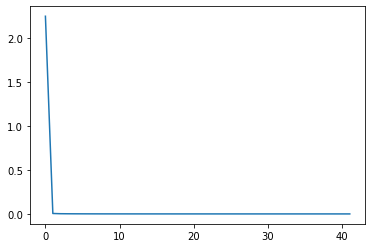

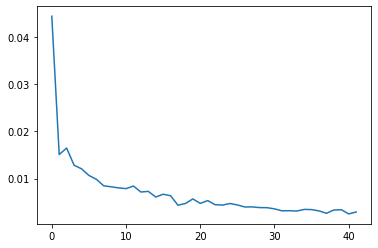

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_history['critic'])
plt.show()
plt.plot(train_history['actor'])

In [20]:
s,r,a,v = next(iter(train_iter))
actions = model.actor_forward(s,r,eval=True)

In [21]:
pd.DataFrame(actions[0].detach().numpy()).head().style.background_gradient()

,0,1,2,3,4,5,6,7,8
0,0.498347,0.466989,0.484945,0.484793,0.525646,0.492653,0.500972,0.477680,0.532169
1,0.498461,0.466919,0.484878,0.484926,0.525650,0.492645,0.500960,0.477653,0.532153
2,0.498509,0.466895,0.484848,0.484986,0.525651,0.492650,0.500957,0.477638,0.532142
3,0.498528,0.466887,0.484837,0.485014,0.525652,0.492653,0.500954,0.477628,0.532139
4,0.498536,0.466884,0.484832,0.485027,0.525653,0.492656,0.500952,0.477623,0.532140


In [22]:
values = model.critic_forward(s[[0]],actions[[0]],eval=True)
values

tensor([[0.0014]], grad_fn=<SliceBackward>)

# 令廠商想要控制某種產出率,其中state(s)不可控,則用法為

In [30]:
wanna_ouput = [describe.loc['75%'][0]]
print(wanna_ouput)
s,r,a,v = next(iter(train_iter))
s = s[0].reshape(-1,time_step,state_size)
r = torch.full((1,1),wanna_ouput[0])
a = model.actor_forward(s,r,eval=True)
v = model.critic_forward(s,a,eval=True)

[0.0001947947148678194]


In [31]:
# 模型建議操作
pd.DataFrame(a[0].detach().numpy()).head().style.background_gradient()

,0,1,2,3,4,5,6,7,8
0,0.498692,0.467034,0.484992,0.484661,0.525846,0.492758,0.501147,0.477871,0.532254
1,0.498847,0.466945,0.484929,0.484737,0.525895,0.492756,0.501204,0.477800,0.532248
2,0.498910,0.466897,0.484893,0.484776,0.525923,0.492756,0.501227,0.477754,0.532229
3,0.498944,0.466875,0.484880,0.484794,0.525943,0.492757,0.501233,0.477738,0.532218
4,0.498962,0.466867,0.484876,0.484802,0.525955,0.492760,0.501234,0.477737,0.532212


In [32]:
# 模型預測根據上述操作應當的產出
print(f'value:{v.detach().numpy()}\n')

value:[[0.00141089]]



In [34]:
values_list = []
for i in tqdm(range(365)):
    s,r,a,v = next(iter(train_iter))
    s = s[0].reshape(-1,time_step,state_size)
    r = torch.full((1,1),wanna_ouput[0])
    a = model.actor_forward(s,r,eval=True)# 模型建議操作
    v = model.critic_forward(s,a,eval=True)
    values_list.append(v.detach().numpy()[0])
values_list = np.array(values_list)

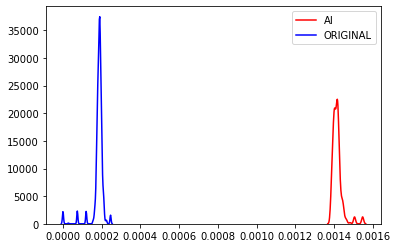

In [38]:
data = joblib.load('..\data\dataset.pkl')
a = pd.DataFrame(data['value'],columns=data['value_col'])
sns.kdeplot(values_list[:,0],label='AI',color='r')
sns.kdeplot(data['value'][:,0],label='ORIGINAL',color='b')
#plt.axvline(x=a.describe().loc['50%'][0], label= "50%", c='k',alpha=0.5)
#plt.axvline(x=a.describe().loc['75%'][0], label= "75%", c='k',alpha=0.5)
plt.legend()
plt.show()

In [39]:
# save weight
torch.save(model.actor.state_dict(),'../model/actor.pth')
torch.save(model.critic.state_dict(),'../model/critic.pth')